In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
from Bio import SeqIO

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.mane_utils import *
from proc_revisions.plotting import *

In [16]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [22]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
dataset_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='dataset')[0]
sample_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
mane_pp = od+expand(config['ref']['new_gtf_aa'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

# orf_fa = '../'+expand(config['data']['p_pred']['orf_fa'], species='human')[0]
# pp_bed = '../'+expand(config['data']['p_pred']['cds_bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]

mouse_ver = 'vM25_cerberus'

# Human 

## What % of novel IC protein coding transcripts are predicted to be NMD or non-coding?

In [92]:
def find_pc_tids(h5,
                 pp_file,
                 filt_ab,
                 species,
                 min_tpm):
    ca = cerberus.read(h5)
    df = pd.read_csv(pp_file, sep='\t')
    iso_df = pd.read_csv(filt_ab, sep='\t')
    iso_df, tids = get_tpm_table(iso_df,
                               how='iso',
                               min_tpm=min_tpm,
                               gene_subset=gene_subset,
                               species=species)
    
    # add novelty to iso df
    feat = 'ic'
    ca = cerberus.read(cerberus_h5)
    temp = ca.ic.copy(deep=True)
    temp = temp[['Name', 'novelty']]
    temp.rename({'Name':'ic'}, axis=1, inplace=True)
    iso_df = add_feat(iso_df, col='index', kind='ic')
    iso_df = iso_df.merge(temp[['Name', 'novelty']], how='left', on='ic')
    temp = iso_df.loc[iso_df.ic_novelty != 'Known']
    
    import pdb; pdb.set_trace()
    
    
    # get tids for each protein pred
    df = df.loc[df.tid.isin(tids)]
    len(df.index)
    
    n = len(temp.index)
    n_num = len(temp.loc[(temp.full_orf == True)&(temp.nmd == False)].index)
    print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of protein coding transcripts with novel ICs have a full ORF and no NMD')
    
    if species == 'human':
        refs = ['v40', 'v29']
    elif species == 'mouse':
        refs = ['vM21', 'vM25']
    
    # number of novel transcripts (including 5' / 3' end)
    ref = ca.t_map.loc[ca.t_map.source.isin(refs)]
    ref_tids = ref.transcript_id.unique().tolist()
    temp = df.loc[~df.tid.isin(ref_tids)]
    n = len(temp.index)
    n_num = len(temp.loc[(temp.nmd == False)&(temp.full_orf == True)].index)
    print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of novel protein coding transcripts have a full ORF and no NMD')

In [ ]:
df = find_pc_tids(cerberus_h5,
             pp_summary,
             filt_ab,
             'human',
             min_tpm=min_tpm)

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 191325


In [83]:
## whadda hecc is happening here
df.head()


In [86]:
ca = cerberus.read(cerberus_h5)
temp = ca.ic.copy(deep=True)
df = add_feat(df, col='index', kind='ic')
df = df.merge(temp[['Name', 'novelty']], how='left', left_on='ic', right_on='Name')


In [90]:
df.head()

,hffc6_1_2,mucosa_of_descending_colon_1_1,hl60_m1_12hr_1_2,ovary_3_1,hct116_1_1,hl60_m2_24hr_1_2,calu3_1_1,caco2_1_2,huvec_1_1,cardiac_septum_1_1,...,ocily7_1_2,heart_left_ventricle_4_1,h9_chondro_1_1,pgp1_1_1,lower_lobe_of_right_lung_1_1,a673_1_2,hepg2_1_1,ic,Name,novelty
0,0.000000,0.000000,0.0,0.000000,1.078233,0.0,1.868680,10.064443,0.000000,0.000000,...,0.0,0.000000,0.837785,0.000000,1.169899,2.510343,3.089794,ENSG00000000003_1,ENSG00000000003_1,Known
1,9.581481,68.713567,0.0,20.443209,8.625867,0.0,36.439267,84.541318,9.831176,0.000000,...,0.0,4.362171,5.864493,25.636599,5.849493,33.471235,43.257112,ENSG00000000003_1,ENSG00000000003_1,Known
2,1.596913,1.908710,0.0,0.000000,3.234700,0.0,1.868680,8.051554,0.578304,0.000000,...,0.0,0.000000,0.000000,0.000000,1.169899,0.836781,3.089794,ENSG00000000003_1,ENSG00000000003_1,Known
3,30.341356,114.522612,0.0,23.850410,26.955834,0.0,102.777420,168.076192,35.854876,4.412956,...,0.0,5.816228,15.917910,51.273199,7.019391,46.022948,82.188513,ENSG00000000003_1,ENSG00000000003_1,Known
4,25.550616,169.875209,0.0,20.443209,17.251734,0.0,74.747214,181.159967,45.686051,0.000000,...,0.0,4.362171,16.755695,34.182133,7.019391,27.613769,40.167319,ENSG00000000003_1,ENSG00000000003_1,Known


In [91]:
df.novelty.unique()

array(['Known', 'NIC', 'ISM', 'NNC'], dtype=object)

In [70]:
# old numbers
# 72.59% (53412/73582) of protein coding transcripts with novel ICs have a full ORF and no NMD
# 77.57% (90283/116395) of novel protein coding transcripts have a full ORF and no NMD

## How often does a non-MANE predominant isoform have the same ORF as the MANE isoform?

In [4]:
def get_mp_orf_table(sg,
                    ca,
                    pp_summary,
                    ref_t_metadata,
                    ref_g_metadata,
                    obs_col,
                    min_feat_tpm):

    mp_df = get_mp_df_table(sg, ca, 
                           ref_t_metadata,
                           ref_g_metadata,
                           obs_col,
                           min_feat_tpm,
                           feat='triplet')

    pp_df = pd.read_csv(pp_summary, sep='\t')

    temp = mp_df.merge(pp_df[['tid', 'seq', 'len', 'nmd', 'full_orf']],
                        how='left',
                        left_on='tid_princ',
                        right_on='tid',
                        suffixes=('', '_orf_princ'))
    temp = temp.merge(pp_df[['tid', 'seq', 'len', 'nmd', 'full_orf']],
                        how='left',
                        left_on='tid_mane',
                        right_on='tid',
                        suffixes=('', '_orf_mane'))

    return temp

In [5]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
temp = get_mp_orf_table(sg,
                ca,
                pp_summary,
                ref_t_metadata,
                ref_g_metadata,
                'dataset',
                min_tpm)

Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/../proc_revisions/data/human/lr/exp_gids_dataset.tsv
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/../proc_revisions/data/human/lr/triplet_dataset_pi_tpm.tsv


In [6]:
temp_back = temp.copy(deep=True)

In [64]:
temp = temp_back.copy(deep=True)

In [65]:
# ensure no entries make it through where tid == [1,1,1] and the mane == princ == True
assert len(temp.loc[(temp.tid_princ.str.contains('\[1,1,1\]'))&(temp.triplet_princ_is_mane==False)]) == 0

# restrict to isos where predominant iso != mane
print(len(temp.index))
temp = temp.loc[temp.triplet_princ_is_mane==False]
print(len(temp.index))

# merge in mane info separately because some entries are null
temp = temp[['tid_princ', 'gid']].drop_duplicates()
meta, _, _ = get_gtf_info(ver='v40_cerberus', how='iso', add_stable_gid=True)
meta = meta.loc[meta.MANE_Select == True]

temp = temp.merge(meta[['tid', 'gid_stable']],
                  how='left',
                  left_on='gid', 
                  right_on='gid_stable')
temp.drop('gid_stable', axis=1, inplace=True)
temp.rename({'tid':'tid_mane'}, axis=1, inplace=True)

pp = pd.read_csv(pp_summary, sep='\t')
pp['gid_stable'] = cerberus.get_stable_gid(pp, 'gid')

# predominant orf
temp = temp.merge(pp[['tid', 'nmd', 'seq', 'full_orf']], how='left', left_on='tid_princ', right_on='tid')
temp.rename({'nmd': 'princ_nmd',
             'seq': 'princ_seq'}, 
            axis=1, inplace=True)

1351449
756666


In [66]:
# mane orf
fasta_sequences = SeqIO.parse(open(mane_pp),'fasta')
tids = []
seqs = []
for fasta in fasta_sequences:
    tid, seq = fasta.id, str(fasta.seq)
    tids.append(tid)
    seqs.append(seq)
mane_df = pd.DataFrame()
mane_df['tid'] = tids
mane_df['seq'] = seqs
mane_df['tid'] = mane_df.tid.str.split('|', expand=True)[1]
ca = cerberus.read(cerberus_h5)
t_map = ca.t_map.loc[ca.t_map.source=='v40']

mane_df = mane_df.merge(t_map[['original_transcript_id', 'transcript_id']],
                        how='left',
                        left_on='tid', 
                        right_on='original_transcript_id')
mane_df.head()
mane_df = mane_df[['transcript_id', 'seq']]
mane_df.rename({'transcript_id':'tid_mane',
                'seq':'seq_mane'}, axis=1, inplace=True)

temp = temp.merge(mane_df, how='left', on='tid_mane')
assert len(temp.loc[temp.seq_mane.isnull()])==0

temp['triplet_princ_orf_is_mane'] = temp['princ_seq'] == temp['seq_mane']


In [67]:
# n = len(temp.loc[temp.triplet_princ_is_mane==False, 'tid_princ'].unique().tolist())
n = len(temp.tid_princ.unique().tolist())
n_num = len(temp.loc[temp.triplet_princ_orf_is_mane==True, 'tid_princ'].unique().tolist())
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of non-MANE predominant transcripts have the same ORF as MANE')

34.98% (20511/58633) of non-MANE predominant transcripts have the same ORF as MANE


In [68]:
temp.head()

,tid_princ,gid,tid_mane,tid,princ_nmd,princ_seq,full_orf,seq_mane,triplet_princ_orf_is_mane
0,"ENSG00000285043[5,14,1]",ENSG00000285043,"ENSG00000285043[1,1,1]","ENSG00000285043[5,14,1]",False,MPYQYPALTPEQKKELSDIAHRIVAPGKGILAADESTGSIAKRLQS...,True,MDASSSPWNPTPAPVSSPPLLLPIPAIVFIAVGIYLLLLGLVLLTR...,False
1,"ENSG00000284862[1,1,8]",ENSG00000284862,"ENSG00000284862[1,1,1]","ENSG00000284862[1,1,8]",False,MSSEFLAELHWEDGFAIPVANEENKLLEDQLSKLKDERASLQDELR...,True,MSSEFLAELHWEDGFAIPVANEENKLLEDQLSKLKDERASLQDELR...,True
2,"ENSG00000284791[1,1,2]",ENSG00000284791,"ENSG00000284791[1,1,1]","ENSG00000284791[1,1,2]",True,MNGSQAGAAAQAAWLSSCCNQSASPPEPPEGPRAVQAVVLGVLSLL...,True,MNGSQAGAAAQAAWLSSCCNQSASPPEPPEGPRAVQAVVLGVLSLL...,True
3,"ENSG00000284770[1,1,2]",ENSG00000284770,"ENSG00000284770[1,1,1]","ENSG00000284770[1,1,2]",False,MSDTLTADVIGRRVEVNGEHATVRFAGVVPPVAGPWLGVEWDNPER...,True,MSDTLTADVIGRRVEVNGEHATVRFAGVVPPVAGPWLGVEWDNPER...,True
4,"ENSG00000284770[1,2,2]",ENSG00000284770,"ENSG00000284770[1,1,1]","ENSG00000284770[1,2,2]",False,MSDTLTADVIGRRVEVNGEHATVRFAGVVPPVAGPWLGVEWDNPER...,True,MSDTLTADVIGRRVEVNGEHATVRFAGVVPPVAGPWLGVEWDNPER...,True


## How often is non-MANE predominant transcript NMD?

In [69]:
n = len(temp.tid_princ.unique().tolist())
n_num = len(temp.loc[(temp.princ_nmd==False)&(temp.full_orf==True), 'tid_princ'].unique().tolist())
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of non-MANE predominant transcripts have a full ORF and no NMD')


92.06% (53977/58633) of non-MANE predominant transcripts have a full ORF and no NMD


## How frequently do predominant transcripts encode for the same ORF?

In [5]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
temp = get_mp_orf_table(sg,
                ca,
                pp_summary,
                ref_t_metadata,
                ref_g_metadata,
                'sample',
                min_tpm)


Read in graph from ../data/human/swan_graph.p
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/../figures/data/human/exp_gids_sample.tsv
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/../figures/data/human/triplet_sample_pi_tpm.tsv


In [7]:
temp_back = temp.copy(deep=True)

In [28]:
temp = temp_back.copy(deep=True)

In [29]:
temp = temp[['tid_princ', 'gid', 'gname', 'seq']]
temp = temp.drop_duplicates()
temp = temp.groupby(['gid', 'gname']).nunique().reset_index()

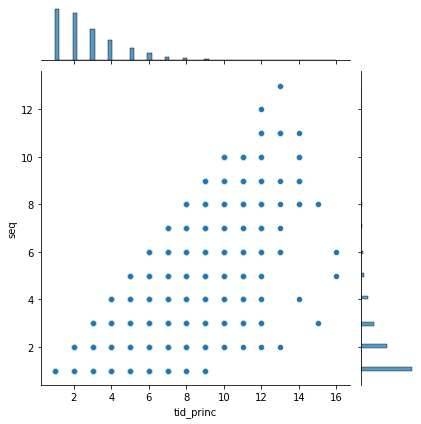

In [33]:
ax = sns.jointplot(temp, x = 'tid_princ', y = 'seq')
# ax.ax_joint.set_xlabel('Number of predominant transcripts')
# ax.set_ylabel('Number of ORFs')

# Mouse

## What % of novel IC protein coding transcripts are predicted to be NMD?

In [11]:
find_pc_tids(m_cerberus_h5,
             m_pp_summary,
             m_filt_ab,
             'mouse',
             min_tpm=min_tpm)

Calculating iso TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 127084
70.58% (34900/49448) of protein coding transcripts with novel ICs have a full ORF and no NMD
77.13% (61066/79169) of novel protein coding transcripts have a full ORF and no NMD
